# 卷积层
1. 图像的平移不变性使我们以相同的方式处理局部图像，而不在乎它的位置。
2. 局部性意味着计算相应的隐藏表示只需一小部分局部图像像素。
$$[\mathbf{H}]_{i, j} = u + \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} [\mathbf{V}]_{a, b}  [\mathbf{X}]_{i+a, j+b}.$$
这是一个卷积层（convolutional layer），而卷积神经网络是包含卷积层的一类特殊的神经网络。 在深度学习研究社区中，V被称为卷积核（convolution kernel）或者滤波器（filter），亦或简单地称之为该卷积层的权重，通常该权重是可学习的参数。 

## 二维互相关运算
![](https://zh-v2.d2l.ai/_images/correlation.svg)

In [12]:
import torch
from torch import nn

# 输入X, 核V, 无边缘填充, 每次滑动1格
def corr2D(X, V):
    out = torch.zeros(X.shape[0]-V.shape[0]+1, X.shape[1]-V.shape[1]+1)
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            out[i, j] = torch.sum(X[i:i+V.shape[0], j:j+V.shape[1]]*V)
    return out
X = torch.arange(9.0).reshape(3, 3)
V = torch.arange(4.0).reshape(2, 2)
corr2D(X, V)

tensor([[19., 25.],
        [37., 43.]])

## 基于互相关函数实现一个卷积层
它以weight和bias为参数. 通过找到像素变化的位置，来检测图像中不同颜色的边缘. 6x8像素的黑白图像。中间四列为黑色（0），其余像素为白色（1）.

In [28]:
class CovLayer(nn.Module):
    def __init__(self, weight):
        super().__init__()
        self.weight = nn.Parameter(weight)
    def forward(self, X):
        return corr2D(X, self.weight)
X = torch.ones(6, 8)
X[:, 2:6] = 0.0
V = torch.tensor([[-1.0, 1]])
margin_detector = CovLayer(V)
o = margin_detector(X)
X, o

(tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
         [1., 1., 0., 0., 0., 0., 1., 1.],
         [1., 1., 0., 0., 0., 0., 1., 1.],
         [1., 1., 0., 0., 0., 0., 1., 1.],
         [1., 1., 0., 0., 0., 0., 1., 1.],
         [1., 1., 0., 0., 0., 0., 1., 1.]]),
 tensor([[ 0., -1.,  0.,  0.,  0.,  1.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  1.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  1.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  1.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  1.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  1.,  0.]], grad_fn=<CopySlices>))

## 通过输入输出学习卷积核

In [38]:
V0 = torch.rand(size=(1, 2))
o = o.detach()
cov_net = CovLayer(V0)
optim = torch.optim.SGD(cov_net.parameters(), lr=0.1)
loss = nn.MSELoss()
epoch = 100
for i in range(epoch):
    op = cov_net(X)
    l = loss(op.reshape(1,-1), o.reshape(1, -1))
    optim.zero_grad()
    l.backward()
    optim.step()
    if i % 10 == 0:
        print(f"step{i+1}, loss={l:.5f}")
print(cov_net.state_dict())  

step1, loss=0.97215
step11, loss=0.30556
step21, loss=0.16018
step31, loss=0.08921
step41, loss=0.04994
step51, loss=0.02796
step61, loss=0.01566
step71, loss=0.00877
step81, loss=0.00491
step91, loss=0.00275
OrderedDict([('weight', tensor([[-0.9266,  0.9266]]))])


### 通过nn.Conv2d()进行构造和训练
nn.Conv2d(  
    in_channels: int,  
    out_channels: int,  
    kernel_size: Union[int, Tuple[int, int]],  
    stride: Union[int, Tuple[int, int]] = 1,  
    padding: Union[str, int, Tuple[int, int]] = 0,  
    dilation: Union[int, Tuple[int, int]] = 1,  
    groups: int = 1,  
    bias: bool = True,  
    padding_mode: str = 'zeros',  
    device=None,  
    dtype=None,  
) -> None

In [51]:
# 这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度），
# 其中批量大小和通道数都为1
X = torch.ones(6, 8)
X[:, 2:6]=0.0
Y = torch.zeros(6, 7)
Y[:, 1] = -1.0
Y[:, 5] = 1.0
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
# 构造一个单一的卷积层, 不考虑偏置
cov2d = nn.Conv2d(1, 1, (1, 2), bias=False)
num_epoch = 10
lr = 3e-2
for epoch in range(num_epoch):
    l = ((cov2d(X) - Y)**2).sum()
    cov2d.zero_grad()
    l.backward()
    cov2d.weight.data[:] -= lr * cov2d.weight.grad
    print(f"In epoch{epoch+1}, loss = {l:.5f}")
print(cov2d.state_dict())

In epoch1, loss = 9.93718
In epoch2, loss = 4.08502
In epoch3, loss = 1.68266
In epoch4, loss = 0.69526
In epoch5, loss = 0.28864
In epoch6, loss = 0.12070
In epoch7, loss = 0.05102
In epoch8, loss = 0.02191
In epoch9, loss = 0.00962
In epoch10, loss = 0.00436
OrderedDict([('weight', tensor([[[[-0.9930,  0.9860]]]]))])


### 通过矩阵操作实现卷积操作
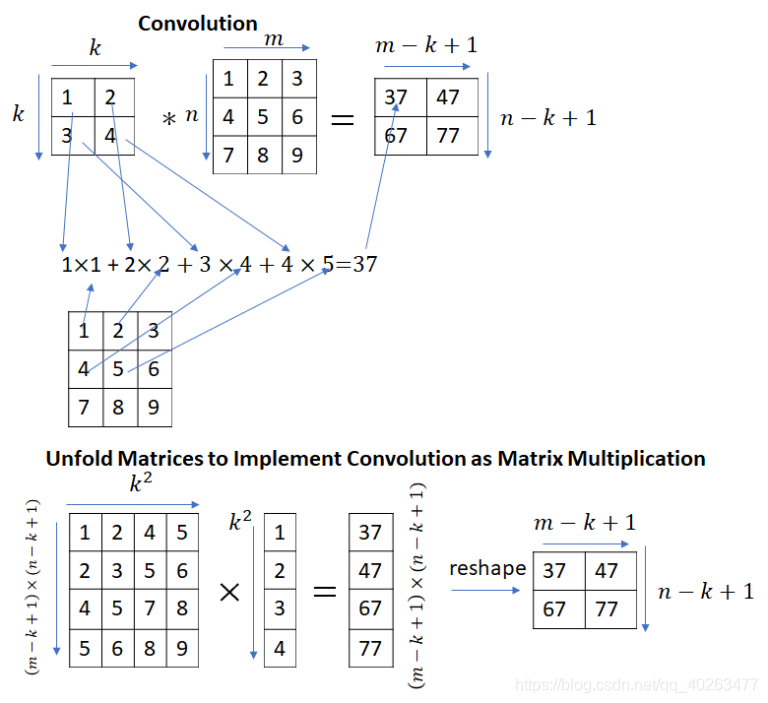